In [1]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
aqt_results = pd.read_csv("../data/AQT/QMarina-AQT-4Q.csv", index_col=0)
aqt_results = aqt_results.set_index(["Time", "Protocol", "Randomizations", "Identities"])

aqt_raw = aqt_results.xs("RAW", level="Protocol")
aqt_times = aqt_raw.index.get_level_values("Time").unique()

# renormalize in the 1-excitation subspace; average emitter 2 and 3
raw_data_norm = aqt_raw.copy()
raw_data_norm[['1000', '0100', '0010', '0001']] = raw_data_norm[['1000', '0100', '0010', '0001']].divide(raw_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
raw_data_norm['avg_0100_0001'] = raw_data_norm[['0100', '0001']].mean(axis=1)

aqt_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0001",
    "Cavity + Environment": "0010",
}

normed_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2 and 3": "avg_0100_0001",
    "Cavity + Environment": "0010",
}

0.29082365223976386

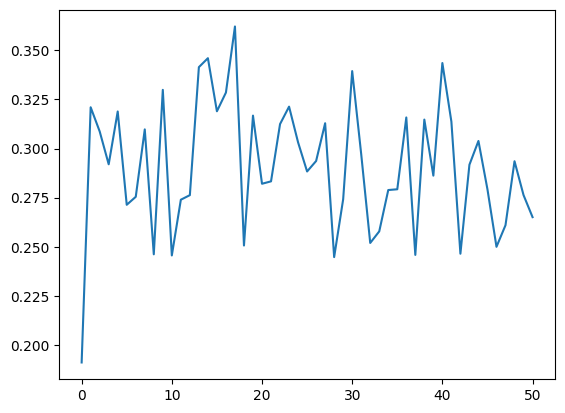

In [3]:
plt.plot((1 - aqt_raw[['1000', '0100', '0010', '0001']].sum(axis=1)).tolist())
(1 - aqt_raw[['1000', '0100', '0010', '0001']].sum(axis=1)).mean()

In [4]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 51)

In [5]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

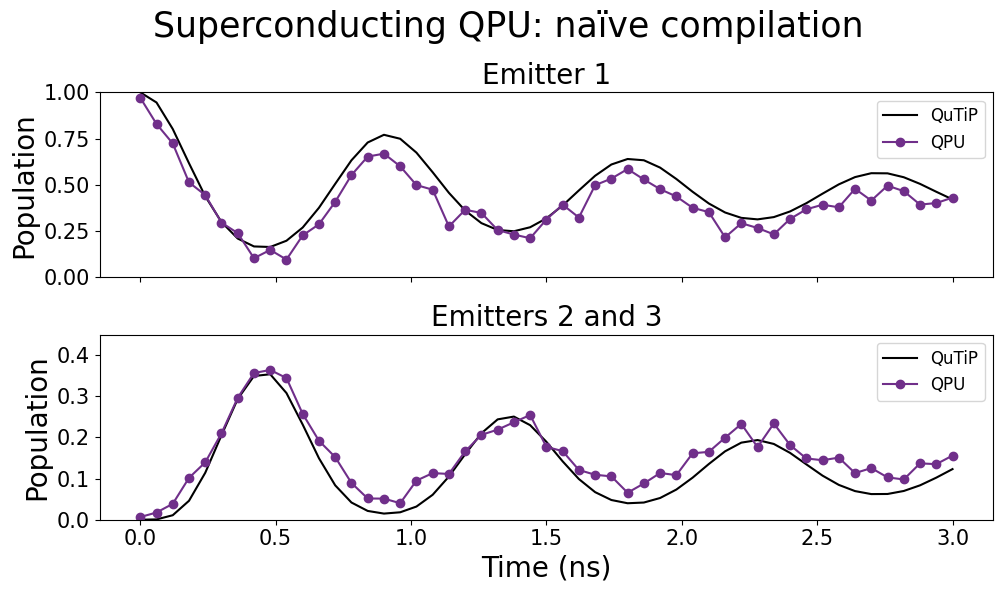

In [6]:
# Plot the RAW (no mitigation) data
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].set_title("Emitter 1", fontsize=20)
# axes[0].plot(aqt_times, aqt_raw[aqt_bitstrs["Emitter 1"]], marker='o', label="QPU (raw)")
axes[0].plot(times, qutip_results["Emitter 1"], label="QuTiP", color='black')
axes[0].plot(aqt_times, raw_data_norm[normed_bitstrs["Emitter 1"]], marker='o', label="QPU", color="#702f8a")
axes[0].set_ylabel("Population", fontsize=20)
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].legend(fontsize=12)

axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].plot(times, qutip_results["Emitter 2"], label="QuTiP", color='black')
axes[1].plot(aqt_times, raw_data_norm[normed_bitstrs["Emitter 2 and 3"]], marker='o', label="QPU", color="#702f8a")
# axes[1].plot(aqt_times, aqt_raw[aqt_bitstrs["Emitter 2"]], marker='o', label="QPU (raw, emitter 2)")
# axes[1].plot(aqt_times, aqt_raw[aqt_bitstrs["Emitter 3"]], marker='o', label="QPU (raw, emitter 3)")
axes[1].set_ylabel("Population", fontsize=20)
axes[1].legend(fontsize=12)

axes[1].set_ylim(0, 0.45)
axes[1].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].set_xlabel("Time (ns)", fontsize=20)

fig.suptitle("Superconducting QPU: naïve compilation", fontsize=25)
plt.tight_layout()


In [7]:
fig.savefig("../figures/AQT_no_error_mitigation.eps", bbox_inches="tight")

In [8]:
from errorbars import calculate_mae_uncertainty, write_results_to_file

for part1, part2 in zip(["Emitter 1", "Emitter 2"], ["Emitter 1", "Emitter 2 and 3"]):
    exp = raw_data_norm[normed_bitstrs[part2]]
    thy = qutip_results[part1]

    results = calculate_mae_uncertainty(exp, thy)
    write_results_to_file(results, processor="AQT", emitter=part1, condition="No err. mit.")